In [2]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from generate_triple_data import par, simulate
import statsmodels.api as sm

%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = (12,9)
plt.rcParams.update({
    k: 'xx-large' for k in plt.rcParams 
    if (
        k.endswith('labelsize') or
        k.endswith('fontsize')
    )
})

In [9]:
data_no_interaction = simulate(par, stim_N=1000, J_AC=0.0, J_BC=0.0, stim_amp_A=6., stim_amp_B=6.)

_,_,C_no_interaction = [s['times'] for s in data_no_interaction['spiketrains']]
stop_time_no_interaction = data_no_interaction['status']['time']

print('\n',
    'Rate of C with interaction (A -> C) {:.2f}'.format(len(C_spikes) / stop_time * 1000), 'Hz \n',
    'Rate of C without interaction (A -|> C) {:.2f}'.format(
        len(C_no_interaction) / stop_time_no_interaction * 1000), 'Hz \n',
    'Difference {:.2f}'.format(
        (len(C_spikes) / stop_time * 1000) - (len(C_no_interaction) / stop_time_no_interaction * 1000)), 'Hz'
)

simulating  42270.0
stimulating  1000

 Rate of C with interaction (A -> C) 22.54 Hz 
 Rate of C without interaction (A -|> C) 15.48 Hz 
 Difference 7.06 Hz


# Visualization

In [10]:
def vlines(X, label=None, **kwargs):
    '''
    Multiple vertical lines spanning the axes
    '''
    a = None
    for i, x in enumerate(X):
        if label and i == len(X)-1:
            kwargs.update({'label': label})
        a = plt.axvline(x, **kwargs)
    return a


def vspans(X, width, label=None, **kwargs):
    '''
    Multiple vertical spans spanning the axes
    '''
    a = None
    for i, x in enumerate(X):
        if label and i == len(X)-1:
            kwargs.update({'label': label})
        a = plt.axvspan(x, x + width, **kwargs)
    return a

Text(0.5,0,'time (ms)')

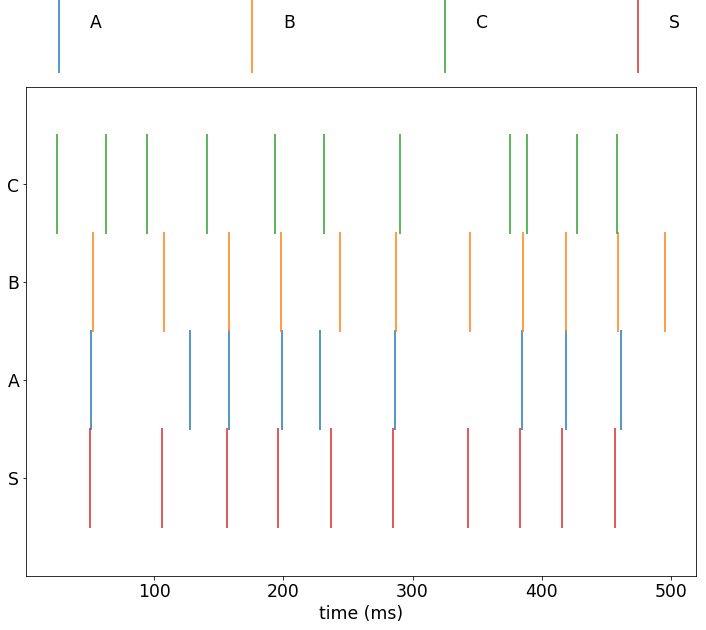

In [11]:
plt.figure()
s = 10000
t0, t1 = 0, 500
A_mask = (A_spikes > t0) & (A_spikes < t1)
B_mask = (B_spikes > t0) & (B_spikes < t1)
C_mask = (C_spikes > t0) & (C_spikes < t1)
S_mask = (stim_times > t0) & (stim_times < t1)
plt.scatter(A_spikes[A_mask], 1.01*np.ones(sum(A_mask)), marker='|', s=s, label='A')
plt.scatter(B_spikes[B_mask], 1.02*np.ones(sum(B_mask)), marker='|', s=s, label='B')
plt.scatter(C_spikes[C_mask], 1.03*np.ones(sum(C_mask)), marker='|', s=s, label='C')
plt.scatter(stim_times[S_mask], 1.*np.ones(sum(S_mask)), marker='|', s=s, label='S')
plt.yticks([1.01, 1.02, 1.03, 1],['A', 'B', 'C', 'S']);
plt.legend(bbox_to_anchor=(0., 1.08, 1., .102), loc=3,
           ncol=4, mode="expand", frameon=False)
plt.ylim(0.99, 1.04)
plt.xlabel('time (ms)')

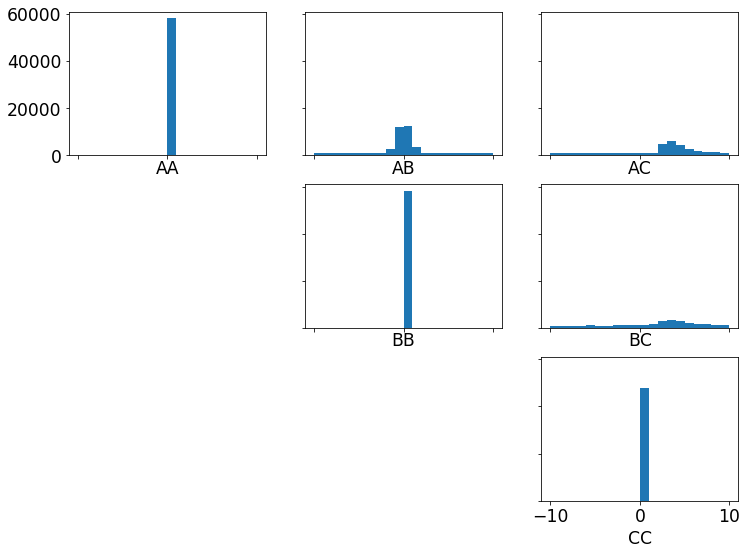

In [12]:
def xcorr(t1, t2, binsize=1e-3, limit=1):
    bins = np.arange(-limit, limit + binsize, binsize)
    ii2 = np.searchsorted(t2, t1 - limit)
    jj2 = np.searchsorted(t2, t1 + limit)
    big = np.concatenate([t2[i:j] - t for t, i, j in zip(t1, ii2, jj2)])
    count, bins = np.histogram(big, bins=bins)
    
    return bins[1:], count

binsize=1
limit=10
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True)
axs = axs.ravel()
cnt = 0
for s1, l1 in zip([A_spikes, B_spikes, C_spikes], ['A', 'B', 'C']):
    for s2, l2 in zip([A_spikes, B_spikes, C_spikes], ['A', 'B', 'C']):
        axs[cnt].bar(*xcorr(s1, s2, binsize=binsize, limit=limit), width=-binsize, align='edge')
        axs[cnt].set_xlabel(l1 + l2)
        cnt += 1
        if cnt in [3,6,7]:
            axs[cnt].remove()

Text(0.5,0,'time lag (stim -> C) (ms)')

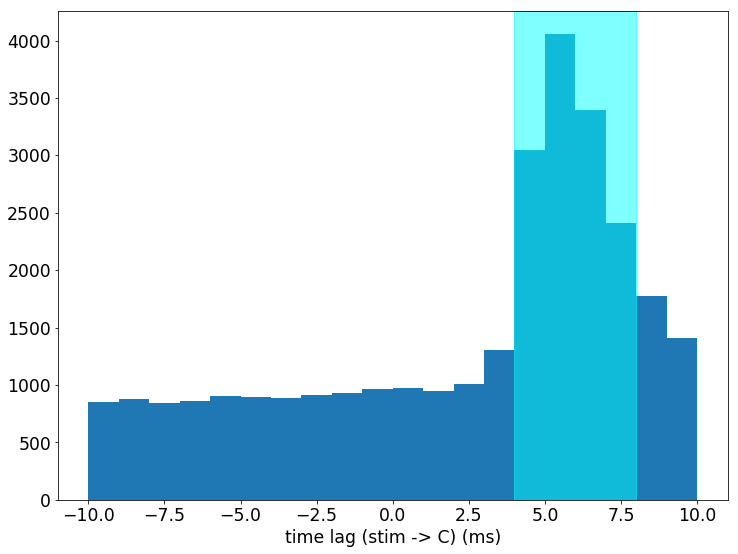

In [13]:
plt.bar(*xcorr(stim_times, C_spikes, binsize=binsize, limit=limit), width=-binsize, align='edge')
plt.axvspan(latency, latency + winsize, alpha=.5, color='cyan')
plt.xlabel('time lag (stim -> C) (ms)')

# Wald

In [14]:
def calculate_response(stim_times, source, target, winsize, latency):
    src = np.searchsorted
    result = {
        'stim_response': (
            # stim response
            src(source, stim_times, 'left') <
            src(source, stim_times + winsize, 'right')),
        'no_stim_response': (
            # stim response
            src(source, stim_times - latency - winsize, 'left') <
            src(source, stim_times - winsize, 'right')),
        'syn_response': (
            # stim synaptic response
            src(target, stim_times + latency, 'left') <
            src(target, stim_times + latency + winsize, 'right')),
        'no_stim_syn_response': (
            # stim response
            src(target, stim_times - winsize, 'left') <
            src(target, stim_times, 'right'))
    }
    return result


def wald(stim_times, source, target, winsize, latency):
    """The IV estimator used in the paper"""
    responses = calculate_response(
        stim_times, source, target, winsize, latency)
    z_s1_x0 = responses['stim_response'] == 0
    z_s1_x1 = z_s1_x0 == False
    
    y_s1_x0 = responses['syn_response'][z_s1_x0]
    y_s1_x1 = responses['syn_response'][z_s1_x1]
    
    y_s1 = (y_s1_x1.mean() - y_s1_x0.mean()) / (z_s1_x1.mean() - z_s1_x0.mean())
    
    z_s0_x0 = responses['no_stim_response'] == 0
    z_s0_x1 = z_s0_x0 == False
    
    y_s0_x0 = responses['no_stim_syn_response'][z_s0_x0]
    y_s0_x1 = responses['no_stim_syn_response'][z_s0_x1]
    
    y_s0 = (y_s0_x1.mean() - y_s0_x0.mean()) / (z_s0_x1.mean() - z_s0_x0.mean())
    return y_s1 - y_s0


def hit_rate(stim_times, source, winsize):
    src = np.searchsorted
    z0 = (# stim response
        src(source, stim_times, 'left') <
        src(source, stim_times + winsize, 'right'))
    z0 = z0 == 0
    z1 = z0 == False
    return z1.mean()

In [15]:
print(
    '\n beta_IV AC {:.2f}'.format(wald(stim_times, A_spikes, C_spikes, winsize, latency)), '\n',
    'beta_IV BC {:.2f}'.format(wald(stim_times, B_spikes, C_spikes, winsize, latency)), '\n',
    'hit rate A {:.2f}'.format(hit_rate(stim_times, A_spikes, winsize)), '\n',
    'hit rate B {:.2f}'.format(hit_rate(stim_times, A_spikes, winsize))
)


 beta_IV AC 0.64 
 beta_IV BC -0.00 
 hit rate A 0.78 
 hit rate B 0.78


# Regression

In [16]:
def create_design_matrix(times, bins, n):
    result = [np.histogram(times, bins=bins)[0]]
    for i in range(1, n):
        result.append(
            np.concatenate([
                np.zeros(i),
                result[0][:-i]
            ])
        )
    return np.array(result)

In [17]:
sigma = 1 # ms
refractory = 3 # ms

bins = np.arange(0, stop_time + sigma, sigma)

In [18]:
A = create_design_matrix(A_spikes, bins, int(refractory / sigma) + 1)

B = create_design_matrix(B_spikes, bins, int(refractory / sigma) + 1)

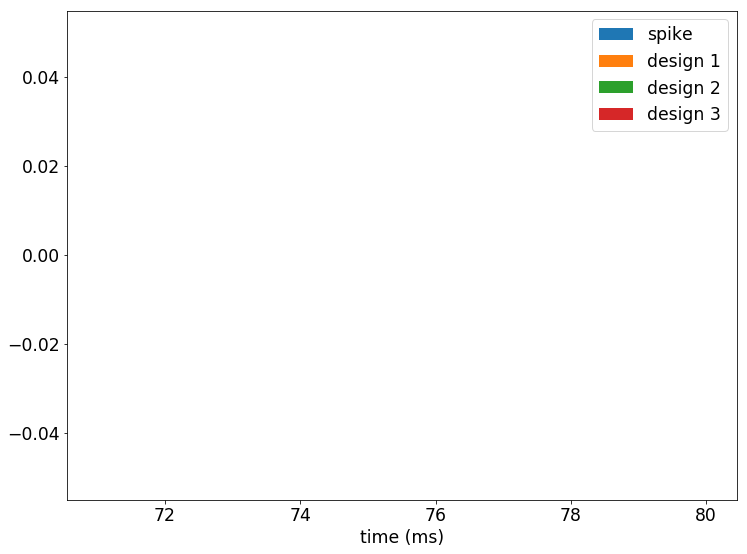

In [19]:
xlim = [70, 80]
mask = (bins[:-1] > xlim[0]) & (bins[:-1] < xlim[1])
mask_spikes = (A_spikes > xlim[0]) & (A_spikes < xlim[1])

for i, a in enumerate(A):
    l = 'spike' if i == 0 else 'design {}'.format(i)
    plt.bar(bins[1:][mask], a[mask], width=-sigma, align='edge', label=l)
    
vlines(A_spikes[mask_spikes], color='k', label='spike')

plt.xlabel('time (ms)')
plt.legend()

In [20]:
S = create_design_matrix(stim_times, bins, int((latency + winsize) / sigma) + 1).sum(axis=0).astype(bool)
# S, _ = np.histogram(stim_times, bins=bins)

In [21]:
C, _ = np.histogram(C_spikes, bins=bins)

(400, 600)

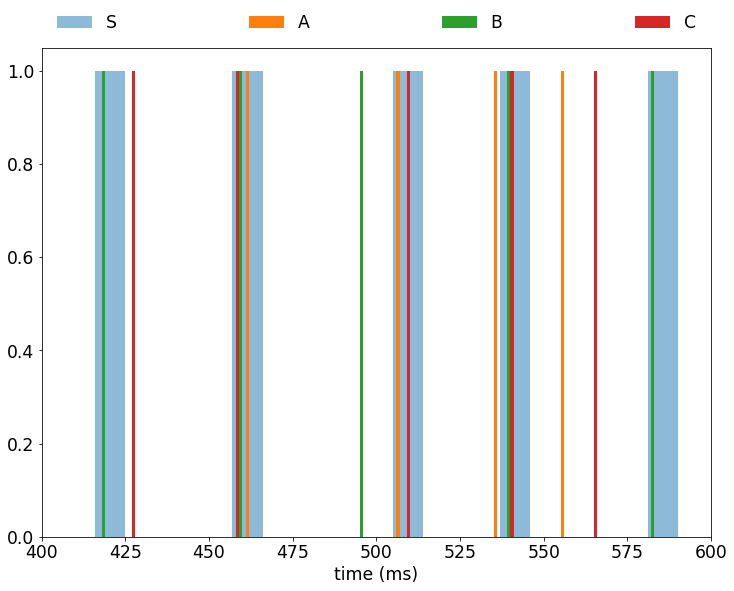

In [22]:
xlim = [400, 600]
mask = (bins[1:] > xlim[0]) & (bins[1:] < xlim[1])
plt.bar(bins[1:][mask], S[mask], width=-sigma, align='edge', label='S', alpha=.5)
plt.bar(bins[1:][mask], A[0][mask], width=-sigma, align='edge', label='A')
plt.bar(bins[1:][mask], B[0][mask], width=-sigma, align='edge', label='B')
plt.bar(bins[1:][mask], C[mask], width=-sigma, align='edge', label='C')
plt.legend(bbox_to_anchor=(0., 1.00, 1., .102), loc=3,
           ncol=4, mode="expand", frameon=False)
plt.xlabel('time (ms)')
plt.xlim(xlim)

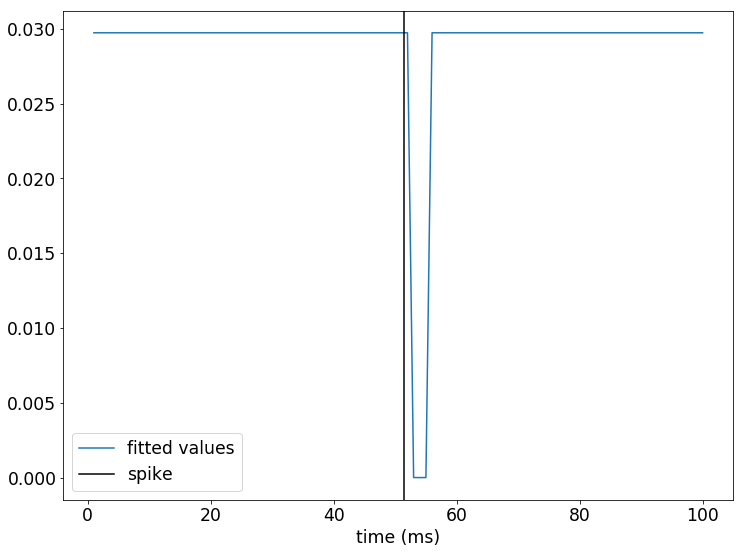

In [23]:
X_A = sm.add_constant(A[1:].T)
model = sm.OLS(A[0], X_A)
AA = model.fit()
plt.plot(bins[1:][:100], AA.fittedvalues[:100], label='fitted values')
plt.axvline(A_spikes[0], color='k', label='spike')
plt.xlabel('time (ms)')
plt.legend()

In [24]:
AA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1779.
Date:                Mon, 03 Jun 2019   Prob (F-statistic):               0.00
Time:                        15:21:24   Log-Likelihood:             8.4337e+05
No. Observations:             2126680   AIC:                        -1.687e+06
Df Residuals:                 2126676   BIC:                        -1.687e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0297      0.000    255.301      0.000       0.030       0.030
x1            -0.0297      0.001    -43.385      0.000      -0.031      -0.028
x2            -0.0297      0.001    -43.385      0.000      -0.031      -0.028
x3            -0.0297      0.001    -43.385      0.000      -0.031      -0.028
==============================================================================
Omnibus:                  2276276.105   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         99668354.981
Skew:                           5.779   Prob(JB):                         0.00
Kurtosis:                      34.483   Cond. No.                         6.33
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
print(
'rate', len(A_spikes) / stop_time * 1000, 'Hz,', 'fit', AA.params[0] / sigma * 1000
)

rate 27.301239490661498 Hz, fit 29.736793449619082


In [26]:
X_B = sm.add_constant(B[1:].T)
model = sm.OLS(B[0], X_B)
BB = model.fit()

In [27]:
B[1:].T

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [28]:
W = np.linalg.lstsq(X_B, B[0], rcond=None)[0]

In [29]:
np.allclose(np.dot(W, X_B.T), BB.fittedvalues)

True

# Second stage without taking stimulus into account

In [30]:
# beta_IV A -> C
np.cov(AA.fittedvalues, C)[0,1] / np.var(AA.fittedvalues)

-1.2462379636472203

In [31]:
# beta_IV B -> C
np.cov(BB.fittedvalues, C)[0,1] / np.var(BB.fittedvalues)

-0.6304421760843171

In [32]:
X_AC = sm.add_constant(AA.fittedvalues)
model = sm.OLS(C, X_AC)
AC = model.fit()
AC.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                 1.001e+04
Date:                Mon, 03 Jun 2019   Prob (F-statistic):               0.00
Time:                        15:21:25   Log-Likelihood:             1.0441e+06
No. Observations:             2126680   AIC:                        -2.088e+06
Df Residuals:                 2126678   BIC:                        -2.088e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0566      0.000    159.415      0.000       0.056       0.057
x1            -1.2462      0.012   -100.070      0.000      -1.271      -1.222
==============================================================================
Omnibus:                  2446992.282   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        149568560.735
Skew:                           6.389   Prob(JB):                         0.00
Kurtosis:                      42.046   Cond. No.                         123.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
X_BC = sm.add_constant(BB.fittedvalues)
model = sm.OLS(C, X_BC)
BC = model.fit()
BC.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2533.
Date:                Mon, 03 Jun 2019   Prob (F-statistic):               0.00
Time:                        15:21:26   Log-Likelihood:             1.0404e+06
No. Observations:             2126680   AIC:                        -2.081e+06
Df Residuals:                 2126678   BIC:                        -2.081e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0397      0.000    111.560      0.000       0.039       0.040
x1            -0.6304      0.013    -50.325      0.000      -0.655      -0.606
==============================================================================
Omnibus:                  2454780.577   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        151430014.055
Skew:                           6.422   Prob(JB):                         0.00
Kurtosis:                      42.293   Cond. No.                         123.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Second stage with stimulus correction

In [34]:
# beta_IV A -> C
np.cov(AA.fittedvalues[S], C[S])[0,1] / np.var(AA.fittedvalues[S])

-0.6981941477981036

In [35]:
# beta_IV B -> C
np.cov(BB.fittedvalues[S], C[S])[0,1] / np.var(BB.fittedvalues[S])

-0.2720482001121619

In [36]:
X_AC = sm.add_constant(AA.fittedvalues[S])
model = sm.OLS(C[S], X_AC)
AC = model.fit()
AC.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     972.9
Date:                Mon, 03 Jun 2019   Prob (F-statistic):          2.32e-213
Time:                        15:21:26   Log-Likelihood:                 84648.
No. Observations:              450000   AIC:                        -1.693e+05
Df Residuals:                  449998   BIC:                        -1.693e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0570      0.001    100.912      0.000       0.056       0.058
x1            -0.6982      0.022    -31.192      0.000      -0.742      -0.654
==============================================================================
Omnibus:                   398786.200   Durbin-Watson:                   2.089
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8142399.618
Skew:                           4.549   Prob(JB):                         0.00
Kurtosis:                      21.748   Cond. No.                         74.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
X_BC = sm.add_constant(BB.fittedvalues[S])
model = sm.OLS(C[S], X_BC)
BC = model.fit()
BC.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     146.6
Date:                Mon, 03 Jun 2019   Prob (F-statistic):           9.90e-34
Time:                        15:21:26   Log-Likelihood:                 84235.
No. Observations:              450000   AIC:                        -1.685e+05
Df Residuals:                  449998   BIC:                        -1.684e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0479      0.001     84.641      0.000       0.047       0.049
x1            -0.2720      0.022    -12.106      0.000      -0.316      -0.228
==============================================================================
Omnibus:                   399595.456   Durbin-Watson:                   2.085
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8197998.672
Skew:                           4.561   Prob(JB):                         0.00
Kurtosis:                      21.815   Cond. No.                         75.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Ratios

In [38]:
AC.params[1] / AA.params[1]

23.479081476570723

In [39]:
BC.params[1] / BB.params[1]

9.175363655366874

# Pre stimulus correction

In [40]:
# we put the entire workflow above into a function:

def IV(pre, post, stim_times, sigma=1, refractory=3, latency=4, winsize=4):

    bins = np.arange(0, stop_time + sigma, sigma)
    
    pre_binary_design = create_design_matrix(
        pre, bins, int(refractory / sigma) + 1)
    pre_binary = pre_binary_design[0]
    pre_design = pre_binary_design[1:]
    
    stim_mask = create_design_matrix(
        stim_times, bins, int((latency + winsize) / sigma) + 1).sum(axis=0).astype(bool)
    
    post_binary, _ = np.histogram(post, bins=bins)
    
    X_pre_design = sm.add_constant(pre_design.T)
    model = sm.OLS(pre_binary, X_pre_design)
    
    pre_model = model.fit()
    
    cov = np.cov(
        pre_model.fittedvalues[stim_mask], 
        post_binary[stim_mask])[0,1]
    beta_IV = cov / np.var(pre_model.fittedvalues[stim_mask])
    return beta_IV

In [41]:
ACr = IV(A_spikes, C_spikes, stim_times - 15)
BCr = IV(B_spikes, C_spikes, stim_times - 15)
ACr, BCr

(-1.320186473262108, -0.01933675189142931)

In [42]:
AC = IV(A_spikes, C_spikes, stim_times)
BC = IV(B_spikes, C_spikes, stim_times)
AC, BC

(-0.6981941477981036, -0.2720482001121619)

In [43]:
AC - ACr, BC - BCr

(0.6219923254640044, -0.2527114482207326)

In [44]:
(AC - ACr) / AA.params[0], (BC - BCr) / BB.params[0]

(20.916590301432514, -8.52321239054318)

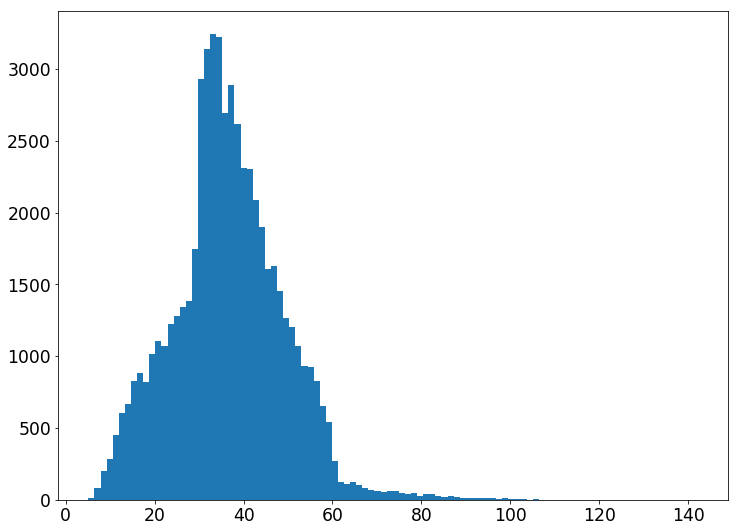

In [47]:
plt.hist(np.diff(A_spikes), bins=100);


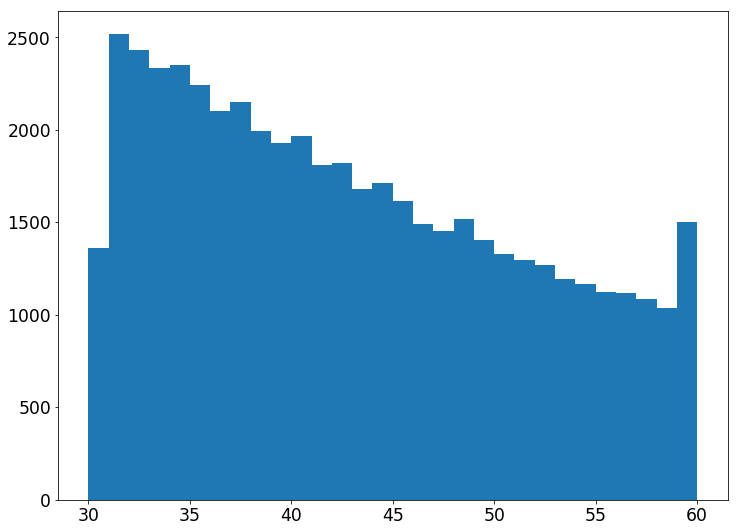

In [51]:
plt.hist(np.diff(stim_times), bins=30);